# This notebook parses behavioral data files and compiles individual subject data. 
 1. BEFORE running this script, run kids_subjectlist.ipynb (to be created) to examine the meta-data. This script can only be run on your local machine with Box mounted because it contains PHI and PII. 
 2. For this specified subjectlist, load each subject's taskdesign file and create a csv of basic stats for each trial (number of pumps, trial type, history effect, pump X reaction time).
 3. Concatinate these csvs into a dataframe:
 
     PID,Trial,NumPumps,TT,HE,1_RT,2_RT,3_RT,4_RT,5_RT,6_RT,7_RT
     777511,2.0,7.0,2.0,5.0,555.0,316.0,461.0,459.0,326.0,476.0,288.0

In [119]:
# Import libraries
import pandas as pd
import numpy as np
import scipy as sp
import os
import os.path as op
import sys
import csv
from subprocess import call
import pdb
from matplotlib import pyplot as plt
import statsmodels as sm
import sklearn

# Preprocessing

In [120]:
# Define functions 

# 0 - lose, 3 - trash, 1 - win, 2 - cashout
def boolfunc12(aa,bb):
        if aa == 1 and bb == 1:
                return 0
        elif aa == 1 and bb == 0:
                return 3
        elif aa == 2:
                return 3
        elif aa == 0 and bb == 1:
                return 1
        elif aa == 0 and bb == 2:
                return 2

def boolfunc23(aa,bb):
        if aa == 1 and bb == 2:
                return 0
        elif aa == 2:
                return 3
        elif aa == 0 and bb == 2:
                return 1
        elif aa == 0 and bb == 3:
                return 2

def boolfunc13(aa,bb):
        if aa == 1 and bb == 1:
                return 0
        elif aa == 1 and bb == 0:
                return 3
        elif aa == 2:
                return 3
        elif aa == 0 and bb == 1:
                return 1
        elif aa == 0 and bb == 3:
                return 2
            
def AAP(dataframe,PID):
    temp = []
    for i,row in dataframe.iterrows():
        if row['PID'] == PID:
            if row['TT'] != 0:
                temp.append(row['NumPumps'])
    AAP = np.mean(temp)
    return AAP

def ABP(dataframe,PID):
    trials,temp,pops = [],[],[]
    for i,row in dataframe.iterrows():
        if row['PID'] == PID:
            trials.append(row['TT'])
            if row['TT'] == 0:
                pops.append(1)
    ABP = len(pops)
    FBP = float(len(pops))/float(len(trials))
    BN = len(trials)
    return ABP,FBP,BN

def RT(dataframe,PID):
    RTs = []
    RTs.append(np.mean(dataframe[dataframe['PID'] == PID]['1_RT']))
    RTs.append(np.mean(dataframe[dataframe['PID'] == PID]['2_RT']))
    RTs.append(np.mean(dataframe[dataframe['PID'] == PID]['3_RT']))
    RTs.append(np.mean(dataframe[dataframe['PID'] == PID]['4_RT']))
    RTs.append(np.mean(dataframe[dataframe['PID'] == PID]['5_RT']))
    RTs.append(np.mean(dataframe[dataframe['PID'] == PID]['6_RT']))
    RTs.append(np.mean(dataframe[dataframe['PID'] == PID]['7_RT']))
    return RTs

In [121]:
# Load in the subjectlist

##### Specify the subjectlist path ####
subjectlist = '/Users/shreyasbharadwaj/Desktop/subjectlist.csv'
#### Specify the number of trials per participant (kids avg 15) ####
num_trials = 15
#### Specify the root path to the project ####
root_path = '/Users/shreyasbharadwaj/Desktop'

subdf = pd.read_csv(subjectlist)
sublist = []

for i,sub in subdf.iterrows():
    sublist.append(str(sub[0])) # +'_'+str(sub[1])+'_'+str(sub[2]))
         

In [122]:
# For each subject, create their HACRT file

for i,sub in enumerate(sublist):
    altsub = sub.split('_')
    altsub = ''.join(altsub)
    bx_path = op.join(root_path)
    if op.exists(bx_path) == False:
        print("Oh well, no behavioral data for: "+str(sub))
        continue
    sub_tsv = os.listdir(bx_path)
    for tsv in sub_tsv:
        if tsv == 'behavioral_BART_7775.tsv':
            bx_df = pd.read_csv(op.join(bx_path,tsv),sep='\t')
            bx_df['PumpNum_Shift'] = bx_df['PumpNum'].shift(1)
            pumpnum_zero = []
            for e,r in bx_df.iterrows():
                if r['PumpNum'] != 0:
                    pumpnum_zero.append(r['PumpNum'])
                else:
                    pumpnum_zero.append(r['PumpNum_Shift']+1)
            bx_df['PumpNum_nonzero'] = pumpnum_zero
            use_bool = set()
            env_resp = 'IsBlow'
            sub_choice = 'PumpStep.RESP'
            hist_tracker = []
            for w in bx_df.iterrows():
                try:
                    use_bool.add(int(w[1][sub_choice]))
                except:
                    pass
                  
            print(sub)
            print("==== Making Trialtype column ====")
            if 2 in use_bool and 1 in use_bool:
                bx_df['TrialType'] = bx_df.apply(lambda row: boolfunc12(row[env_resp],row[sub_choice]),axis=1)
            elif 2 in use_bool and 3 in use_bool:
                bx_df['TrialType'] = bx_df.apply(lambda row: boolfunc23(row[env_resp],row[sub_choice]),axis=1)
            elif 1 in use_bool and 3 in use_bool:
                bx_df['TrialType'] = bx_df.apply(lambda row: boolfunc13(row[env_resp],row[sub_choice]),axis=1)
            else:
                continue
            
            reaction_times = np.zeros((14,15))
            
            x = 0
            for e,r in bx_df.iterrows():
                x = r['BalloonList.Sample'] - 1
                if(r['PumpNum'] == 0):
                    reaction_times[int(x)][int(7+r['PumpNum_Shift'])+1] = r['PumpStep.RT']
                else:
                    reaction_times[int(x)][int(r['PumpList.Sample'] - 1)] = r['PumpStep.RT']
            
            print("==== Making HistEffect column ====")
            bx_df['TrialShift'] = bx_df['Trial'].shift(-1)
            dragon = 0
            for p in bx_df.iterrows():
                hist_tracker.append(dragon)
                if p[1]['IsBlow'] == 1 and p[1]['TrialShift'] != p[1]['Trial']+1:
                    dragon = 5
                elif p[1]['IsBlow'] == 0 and p[1]['TrialShift'] != p[1]['Trial']+1:
                    dragon = 3
            se = pd.Series(hist_tracker)
            bx_df['HE'] = se.values
            sub_IP = np.zeros((14,19)) # (create 14 x 4 array)
            for x in range(int(bx_df['Block'][-1:])):
                for j,row in bx_df.iterrows():
                    if row['Block'] == x+1:
                        try:
                            sub_IP[x,0] = int(row['Block'])
                            sub_IP[x,1] = int(row['PumpNum_nonzero'])
                            sub_IP[x,2] = int(row['TrialType'])
                            sub_IP[x,3] = int(row['HE'])
                        except:
                            pass
                    else:
                        continue
            for i in range(14):
                for j in range(15):
                    sub_IP[i,j+4] = reaction_times[i,j]
                with open(op.join(root_path,'HACRT_'+altsub+'.csv'),'w') as csvfile:
                    wwriter = csv.writer(csvfile,delimiter=',')
                    wwriter.writerow(['Trial','NumPumps','TT','HE','1_RT','2_RT','3_RT','4_RT','5_RT','6_RT','7_RT','8_RT',"RT1_CO","RT2_CO","RT3_CO","RT4_CO","RT5_CO","RT6_CO","RT7_CO"])
                    for i in range(len(sub_IP)):
                        wwriter.writerow(list(sub_IP[i]))


7775
==== Making Trialtype column ====
==== Making HistEffect column ====
7776
==== Making Trialtype column ====
==== Making HistEffect column ====
7787
==== Making Trialtype column ====
==== Making HistEffect column ====


In [123]:
# Read in all the HACRT files, concatinate them, and calculate ABP, BP, FBP

HACRT_list = []

for sub in sublist:
    print(sub)
    HACRT_path = op.join(root_path,'HACRT_'+sub[0:4]+'.csv')
    HACRT_list.append(HACRT_path)
    
GroupHACRT = pd.DataFrame()
list_ = []
for HAC in HACRT_list:
    PID = HAC[-10:-4]
    df = pd.read_csv(HAC,index_col=None, header=0)
    df['PID'] = PID
    df['AAP'] = AAP(df,PID)
    df['BP'] = ABP(df,PID)[0]
    df['FBP'] = ABP(df,PID)[1]
    df['BN'] = ABP(df,PID)[2]
    df['avgRT1'] = RT(df,PID)[0]
    df['avgRT2'] = RT(df,PID)[1]
    df['avgRT3'] = RT(df,PID)[2]
    df['avgRT4'] = RT(df,PID)[3]
    df['avgRT5'] = RT(df,PID)[4]
    df['avgRT6'] = RT(df,PID)[5]
    df['avgRT7'] = RT(df,PID)[6]
    list_.append(df)
GroupHACRT = pd.concat(list_)

print(GroupHACRT)

7775
7776
7787
    Trial  NumPumps   TT   HE    1_RT    2_RT    3_RT    4_RT   5_RT    6_RT  \
0     1.0       8.0  0.0  0.0   475.0   473.0   376.0   589.0  544.0   579.0   
1     2.0       7.0  2.0  5.0   555.0   316.0   461.0   459.0  326.0   476.0   
2     3.0       6.0  0.0  3.0   405.0   394.0   366.0   664.0  352.0   400.0   
3     4.0       2.0  0.0  5.0   729.0   425.0     0.0     0.0    0.0     0.0   
4     5.0       7.0  2.0  5.0   806.0  1913.0  1951.0   972.0  570.0   622.0   
5     6.0       6.0  2.0  3.0   634.0   576.0   478.0   634.0  725.0     0.0   
6     7.0       4.0  0.0  3.0  1454.0   519.0   458.0   432.0    0.0     0.0   
7     8.0       7.0  2.0  5.0   692.0   455.0  1054.0   862.0  464.0  1101.0   
8     9.0       4.0  2.0  3.0   890.0   584.0   915.0     0.0    0.0     0.0   
9    10.0       2.0  0.0  3.0   459.0   380.0     0.0     0.0    0.0     0.0   
10   11.0       7.0  2.0  5.0   500.0   770.0   640.0   797.0  668.0  1266.0   
11   12.0       4.0  2.0 

# Basic Analysis 

 Average Adjusted Pumps across all subjects: 5.875
 Average number of balloons popped across all subjects: 6.0
 Average fraction of balloons popped across all subjects: 0.4285714285714285
 Average number of balloons across all subjects: 14.0
748.3571428571429
698.4285714285716
260.64285714285717


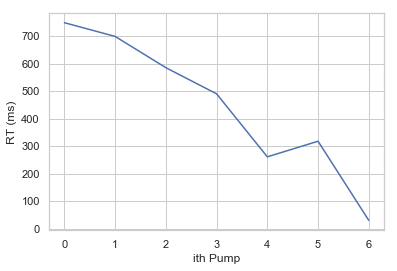

In [124]:
# Average AAP,BP,FBP group averages of below per-subject measures

# AAP = average adjusted pumps (avg number of pumps on non-popped balloons)
# BP = number of balloons popped
# FBP = fraction of balloons popped out of all balloons 
# BN = number of balloon trials 

GroupAAP = np.mean(GroupHACRT['AAP'])
GroupBP = np.mean(GroupHACRT['BP'])
GroupFBP = np.mean(GroupHACRT['FBP'])
GroupBN = np.mean(GroupHACRT['BN'])

print(" Average Adjusted Pumps across all subjects: "+str(GroupAAP))
print(" Average number of balloons popped across all subjects: "+str(GroupBP))
print(" Average fraction of balloons popped across all subjects: "+str(GroupFBP))
print(" Average number of balloons across all subjects: "+str(GroupBN))

# Average reaction time for ith pump

GroupRT1 = np.mean(GroupHACRT['avgRT1'])
GroupRT2 = np.mean(GroupHACRT['avgRT2'])
GroupRT3 = np.mean(GroupHACRT['avgRT3'])
GroupRT4 = np.mean(GroupHACRT['avgRT4'])
GroupRT5 = np.mean(GroupHACRT['avgRT5'])
GroupRT6 = np.mean(GroupHACRT['avgRT6'])
GroupRT7 = np.mean(GroupHACRT['avgRT7'])

print(GroupRT1)
print(GroupRT2)
print(GroupRT5)
plt.plot([GroupRT1,GroupRT2,GroupRT3,GroupRT4,GroupRT5,GroupRT6,GroupRT7])
plt.xlabel('ith Pump')
plt.ylabel('RT (ms)')
plt.show()


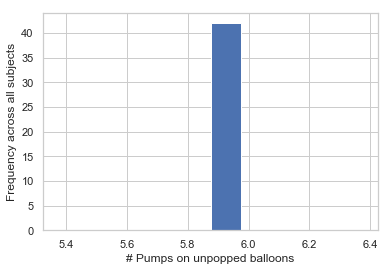

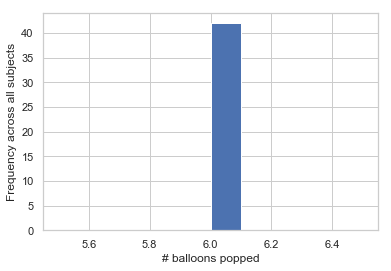

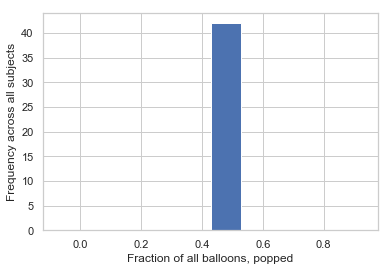

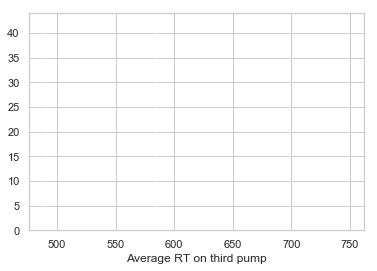

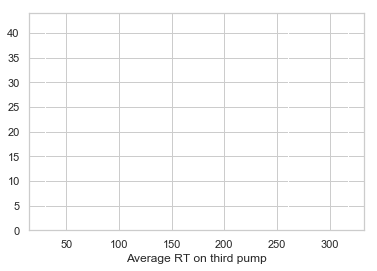

In [125]:
# Plot the averages and per-subject info

# Histogram of AAP
plt.hist(GroupHACRT['AAP'])
plt.xlabel('# Pumps on unpopped balloons')
plt.ylabel('Frequency across all subjects')
plt.show()

# Histogram of BP
plt.hist(GroupHACRT['BP'])
plt.xlabel('# balloons popped')
plt.ylabel('Frequency across all subjects')
plt.show()

# Histogram of FBP
plt.hist(GroupHACRT['FBP'])
plt.xlabel('Fraction of all balloons, popped')
plt.ylabel('Frequency across all subjects')
plt.show()

plt.figure()
plt.hist(GroupHACRT['avgRT1'])
plt.xlabel('Average RT on first pump')
plt.hist(GroupHACRT['avgRT2'])
plt.xlabel('Average RT on second pump')
plt.hist(GroupHACRT['avgRT3'])
plt.xlabel('Average RT on third pump')
plt.hist(GroupHACRT['avgRT4'])
plt.xlabel('Average RT on third pump')
plt.show()

plt.figure()
plt.hist(GroupHACRT['avgRT5'])
plt.xlabel('Average RT on first pump')
plt.hist(GroupHACRT['avgRT6'])
plt.xlabel('Average RT on second pump')
plt.hist(GroupHACRT['avgRT7'])
plt.xlabel('Average RT on third pump')
plt.show()


# History Effect Analysis 

In [126]:
# Plot the averages and per-subject info for the HISTORY EFFECT

postC = GroupHACRT[GroupHACRT['HE'] == 3]
postE = GroupHACRT[GroupHACRT['HE'] == 5]

postC_RT1 = np.mean(postC['avgRT1'])
postE_RT1 = np.mean(postE['avgRT1'])
postC_RT2 = np.mean(postC['avgRT2'])
postE_RT2 = np.mean(postE['avgRT2'])

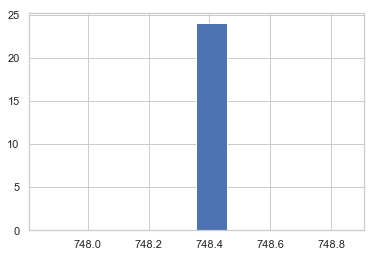

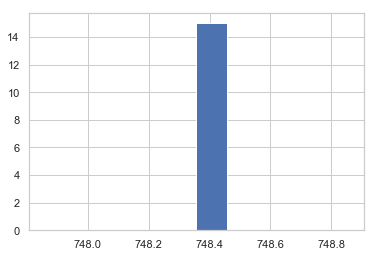

In [127]:
plt.hist(postC['avgRT1'])
plt.show()

plt.hist(postE['avgRT1'])
plt.show()

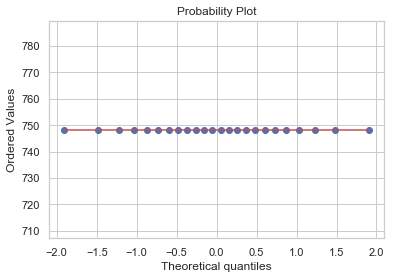

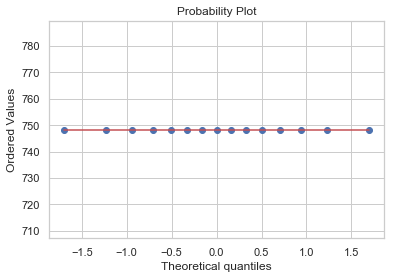

Ttest_indResult(statistic=-5.90006871238046, pvalue=1.948861088061682e-06)
Ttest_indResult(statistic=2106215825594954.8, pvalue=0.0)


In [128]:
# Significance tests
from scipy import stats

# Q-Q plot to test for normal distribution
stats.probplot(postC['avgRT1'], plot= plt)
plt.show()

stats.probplot(postE['avgRT1'], plot= plt)
plt.show()

# Paired t-test between RT ith's
rt1_test = stats.ttest_ind(postC['avgRT1'],postE['avgRT1'], equal_var = False)
print(rt1_test)

rt2_test = stats.ttest_ind(postC['avgRT1'],postC['avgRT2'], equal_var = False)
print(rt2_test)

In [129]:

postC_RTs = [postC['avgRT1'],postC['avgRT2']]
postE_RTs = [postE['avgRT1'],postE['avgRT2']]
print(len(postC_RTs[0]))
print(len(postE_RTs[0]))
t = stats.ttest_ind(postC_RTs[0],postE_RTs[1], equal_var = False)
print(t)

24
15
Ttest_indResult(statistic=765444940626245.2, pvalue=1.1613173409795813e-262)


[288.0, 400.0, 425.0, 465.0, 515.0, 432.0, 394.0, 376.0, 380.0, 633.0, 442.0, 1975.0, 895.0]
[5.0, 3.0, 5.0, 5.0, 3.0, 3.0, 5.0, 3.0, 3.0, 5.0, 3.0, 3.0, 3.0]
(13, 2)
[[4]]
             precision    recall  f1-score   support

          0       1.00      1.00      1.00         4

avg / total       1.00      1.00      1.00         4



array([161, 187, 233, 223, 254, 215, 182, 192, 184, 293, 227, 979, 418])

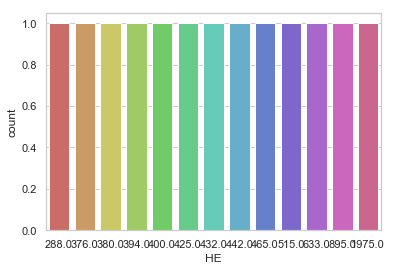

In [138]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt 
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report
plt.rc("font", size=14)

last_reaction_times = []
for i in range(1,14):
    for j in range(15):
        if(reaction_times[i][14-j] != 0):
            last_reaction_times.append(reaction_times[i][14-j])
            break
print(last_reaction_times)
historical_effect = []
for i in range(1,14):
    historical_effect.append(sub_IP[i][3])
data_ = np.zeros((13,2))
for x in range(13):
    data_[x][0] = last_reaction_times[x]
    data_[x][1] = historical_effect[x]
print(historical_effect)
with open(op.join(root_path,'HACRT_'+altsub+'HISTEFFECTANALYSIS.csv'),'w') as csvfile:
    wwriter = csv.writer(csvfile,delimiter=',')
    wwriter.writerow(['HE','Reaction Time'])
    for x in range(13):
        wwriter.writerow(data_[x])
    
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)
data = pd.read_csv('/Users/shreyasbharadwaj/Desktop/HACRT_7787HISTEFFECTANALYSIS.csv', header=0)
data = data.dropna()
print(data.shape)
sns.countplot(x='HE',data=data, palette='hls')
data2 = pd.get_dummies(data, columns = ['HE','Reaction Time'])
X = data2.iloc[:,5:]
y = data2.iloc[:,1]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
classifier = LogisticRegression(random_state=0)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)
print(classification_report(y_test, y_pred))


regr = linear_model.LinearRegression()
regr.fit(data_, historical_effect)
# print('Coefficients: \n', regr.coef_)
np.random.binomial(last_reaction_times, 0.5)
